#CNN Model

## Preprocessing

In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keras-tuner -q

In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#google colab mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import glob as gb
import cv2
import tensorflow as tf
import os


#sklearn
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#For image preprocessing
from  tensorflow.keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#for google colab, primary computer
augmented_images_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Augmented Images'
test_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test'
train_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Train'
val_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Val'
original_image_path= '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Original Images'
test_path = '/content/drive/MyDrive/DSI30/Capstone/Datasets/onemonkeypoxskinlesion/Fold1/Test'

In [ ]:
#seeing what we have to work on

for folder in  os.listdir(original_image_path) : 
    files = gb.glob(pathname= str(original_image_path +'/' + folder + '/*.jpg'))
    print(f'Original image, Found {len(files)} in folder {folder}')
for folder in  os.listdir(augmented_images_path) : 
    files = gb.glob(pathname= str(augmented_images_path +'/' + folder + '/*.jpg'))
    print(f'Augmented image, Found {len(files)} in folder {folder}')
for folder in  os.listdir(test_path) : 
    files = gb.glob(pathname= str(test_path +'/' + folder + '/*.jpg'))
    print(f'Test folders, Found {len(files)} in folder {folder}')
for folder in  os.listdir(train_path) : 
    files = gb.glob(pathname= str(train_path +'/' + folder + '/*.jpg'))
    print(f'Train folders, Found {len(files)} in folder {folder}')
for folder in  os.listdir(val_path) : 
    files = gb.glob(pathname= str(val_path +'/' + folder + '/*.jpg'))
    print(f'Val folders, Found {len(files)} in folder {folder}')

Original image, Found 102 in folder Monkey Pox
Original image, Found 126 in folder Others
Augmented image, Found 1428 in folder Monkeypox_augmented
Augmented image, Found 1764 in folder Others_augmented
Test folders, Found 25 in folder Others
Test folders, Found 20 in folder Monkeypox
Train folders, Found 1162 in folder Others
Train folders, Found 980 in folder Monkeypox
Val folders, Found 168 in folder Monkeypox
Val folders, Found 252 in folder Others


In [ ]:
#looking at the size of images in train image set
size = []
for folder in  os.listdir(train_path) : 
    files = gb.glob(pathname= str( train_path +'/' + folder + '/*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
        
pd.Series(size).value_counts()

(224, 224, 3)    2142
dtype: int64

**Dimensions of of all 2142 processed train images is 224 by 224**

In [ ]:
#looking at the size of images in original image set
size = []
for folder in  os.listdir(original_image_path) : 
    files = gb.glob(pathname= str( original_image_path +'/' + folder + '/*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
        
pd.Series(size).value_counts()

(224, 224, 3)    228
dtype: int64

**Dimensions of of all 228 original images is 224 by 224**

In [ ]:
#set up code to differenciate monkeypox and others
code = {'Others':0 ,'Monkeypox':1}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x  

In [ ]:
size = []
for folder in  os.listdir(train_path) : 
    files = gb.glob(pathname= str( train_path +'/' + folder + '/*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
        
pd.Series(size).value_counts()

(224, 224, 3)    2142
dtype: int64

Preprocessing the Training set
Image augmentation should be done to avoid overfitting

It is a technique of creating new data from existing data by applying some transformations such as flips, rotate at a various angle, shifts, zooms and more. More data means higher accuracy. Often, we would have limited data. Therefore, data augmentation is often used to increase train dataset.

transformations such as:
Translations
Rotations
Shearing
Changes in scale
Image fliping
Zooming

In [ ]:
#image processing
#duplicated original train folder
X = []
y = []

#kernel 
# kernel = np.ones((5,5),np.uint8)
kernel_sharpening = np.array([[-1,-1,-1],
                                 [-1,9,-1],
                                 [-1,-1,-1]])

for folder in  os.listdir(train_path) : 
    files = gb.glob(pathname= str(train_path +'/' + folder + '/*.jpg'))
    for file in files: 
        #read file
        image = cv2.imread(file)
        #sharpening image
        sharpen =cv2.filter2D(image, -1,kernel_sharpening)
        #erosion and dilation to remove noise from image
        #sharpen_erosion = cv2.erode(sharpen, kernel, iterations =10)
        #sharpen_erosion_dilation = cv2.dilate(sharpen_erosion, kernel, iterations =10)
        #resize to 64 by 64
        #use INTER_LINEAR or INTER_CUBIC(higher quality) for enlarging, INTER_AREA for shrinking
        image_array = cv2.resize(sharpen , (64,64), interpolation = cv2.INTER_AREA)
        #store 64 by 64 image array to X
        X.append(list(image_array))
        #label each file with code and folder name in list y
        y.append(code[folder])

In [ ]:
print(f'we have {len(X)} items in training set')

we have 2142 items in training set


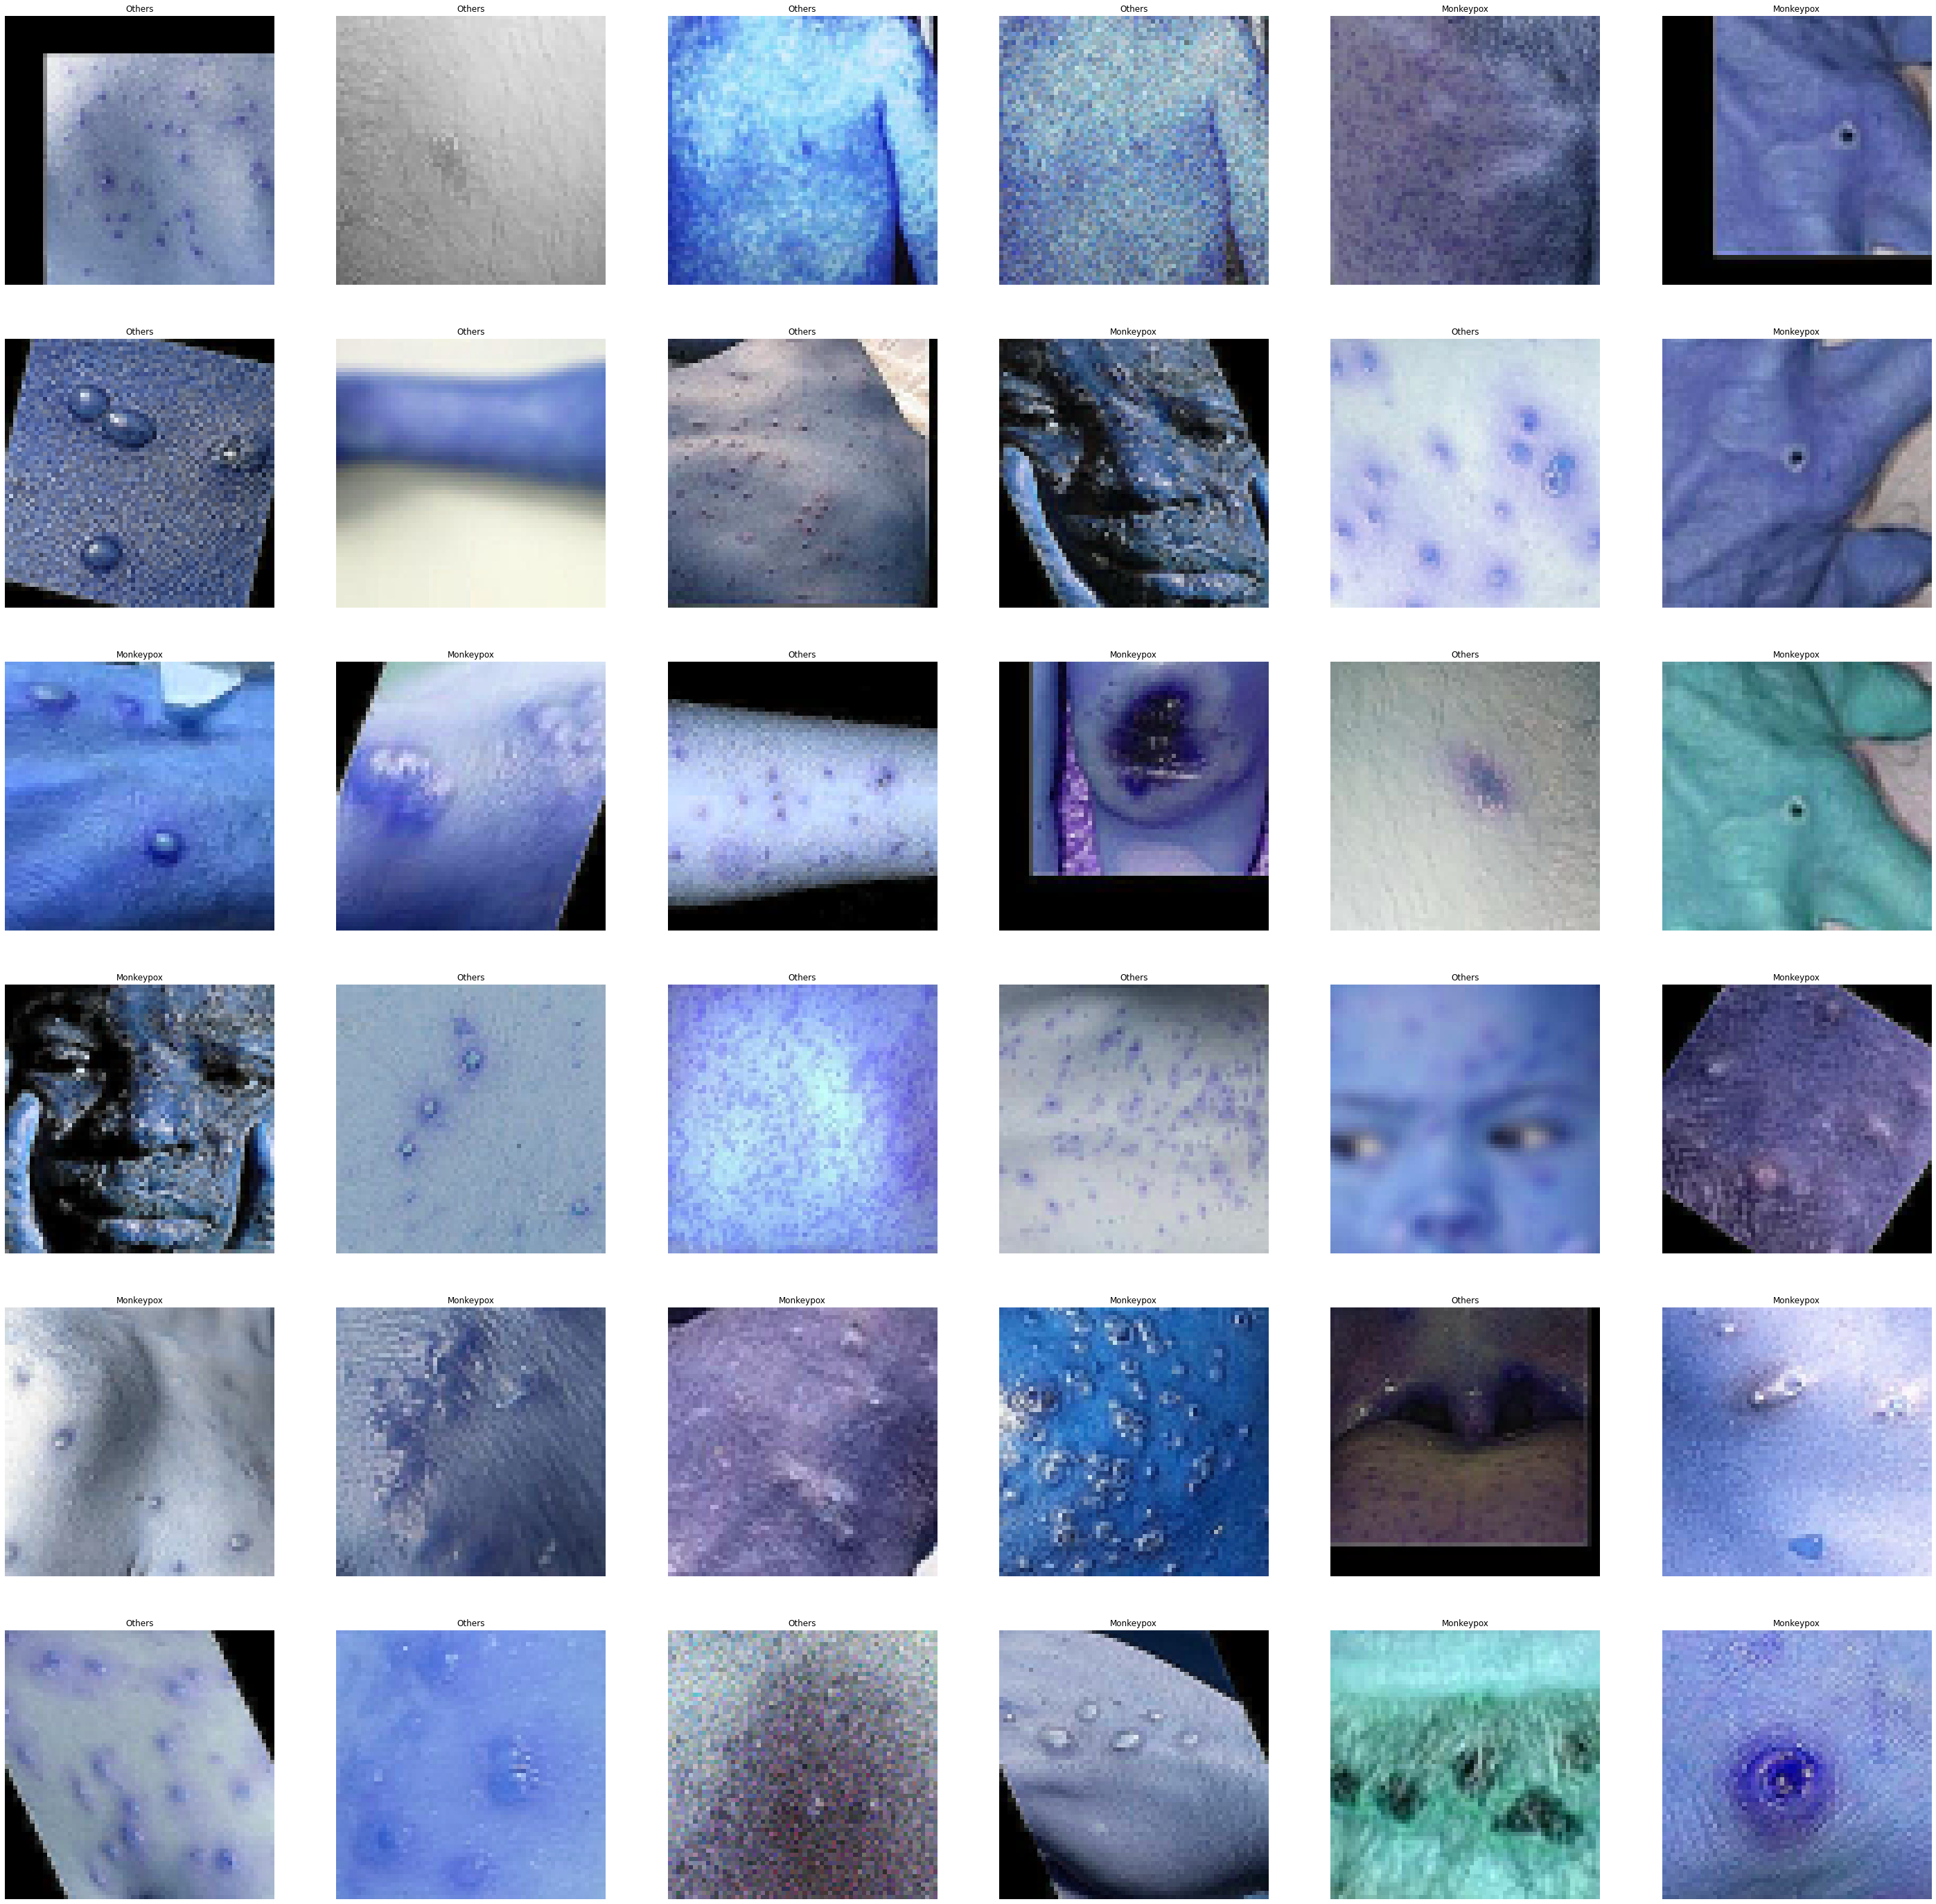

In [ ]:
plt.figure(figsize=(50,50))
for n , i in enumerate(list(np.random.randint(0,len(X),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X[i])   
    plt.axis('off')
    plt.title(getcode(y[i]))

Keras ImageDataGenerator

Take a batch of images used for training.
Apply random transformations to each image in the batch.
Replacing the original batch of images with a new randomly transformed batch.
Train a Deep Learning model on this transformed batch.
rescale for scaling every pixel in the image (each pixel is between 0 to 255 so, the result will be between 0 and 1)

Keras’ ImageDataGenerator class provide three different functions to loads the image dataset in memory and generates batches of augmented data. These three functions are:

.flow()

.flow_from_directory()

.flow_from_dataframe.()

The flow_from_directory() method takes a path of a directory and generates batches of augmented data it assumes:

The root directory contains at least two folders one for train and one for the test.

The train folder should contain n sub-directories each containing images of respective classes.

The test folder should contain a single folder, which stores all test images.

In [ ]:
training_set = preprocessing.image_dataset_from_directory(directory=train_path,
                                                 image_size = (64, 64),
                                                 batch_size = 32,
                                                 label_mode="binary")
test2_set = preprocessing.image_dataset_from_directory(directory=test_path,
                                            image_size = (64, 64),
                                            batch_size = 32,
                                            label_mode="binary",
                                            shuffle=False)
val2_set = preprocessing.image_dataset_from_directory(directory=val_path,
                                            image_size = (64, 64),
                                            batch_size = 32,
                                            label_mode="binary",
                                            shuffle=False)

Found 2142 files belonging to 2 classes.
Found 45 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [ ]:
# training_set.class_indices

### CNN Model

In [ ]:
#initialising CNN
cnnmodel = Sequential()

In [ ]:
#Building CNN
#32 feature detectors (kernals)
#Kernal size 3*3
# relu as activation function to increase the non linearity of the image
# 64*64 RGB  images
# BatchNormalization is added in between layers

cnnmodel.add(Conv2D(filters=32,kernel_size=3, activation='relu',input_shape=(64,64,3)))
cnnmodel.add(BatchNormalization())
#pooling minimize size of images and parameters, prevent overfitting
cnnmodel.add(MaxPooling2D(pool_size=2,strides=2))
cnnmodel.add(BatchNormalization())
cnnmodel.add(Conv2D(filters=32,kernel_size=3, activation='relu',input_shape=(64,64,3)))
cnnmodel.add(BatchNormalization())
cnnmodel.add(MaxPooling2D(pool_size=2,strides=2))
cnnmodel.add(BatchNormalization())
#GlobalAveragePooling2D layer /flattening
#cnnmodel.add(Flatten())
cnnmodel.add(GlobalAveragePooling2D())
cnnmodel.add(BatchNormalization())
cnnmodel.add(Dense(units=3130,activation='relu'))
cnnmodel.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
#full connection, creating a fully connected layer
cnnmodel.add(Dense(units=128,activation='relu'))
cnnmodel.add(Dropout(0.4))
#output layer
cnnmodel.add(Dense(units=1,activation='sigmoid'))

# output shape
cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                        

In [ ]:
cnnmodel.compile(
    optimizer='adam',
    loss='binary_crossentropy', #loss="categorical_crossentropy", 
    metrics=["acc"])

In [ ]:
# checkpoint and early stopping
filepath="/content/drive/MyDrive/DSI30/Capstone/weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_acc',mode='max', patience=10)
callbacks_list = [checkpoint, es]

In [ ]:
# fitting model with train set

hist = cnnmodel.fit(
    x = training_set,  validation_data = val2_set,
    batch_size=32,
    callbacks=[callbacks_list],
    epochs=300)

Epoch 1/300
67/67 [==============================] - ETA: 0s - loss: 1.6755 - acc: 0.5761
Epoch 1: val_acc improved from -inf to 0.69524, saving model to /content/drive/MyDrive/DSI30/Capstone/weights.hdf5
67/67 [==============================] - 58s 838ms/step - loss: 1.6755 - acc: 0.5761 - val_loss: 0.6994 - val_acc: 0.6952
Epoch 2/300
67/67 [==============================] - ETA: 0s - loss: 1.2843 - acc: 0.5952
Epoch 2: val_acc did not improve from 0.69524
67/67 [==============================] - 23s 334ms/step - loss: 1.2843 - acc: 0.5952 - val_loss: 1.6556 - val_acc: 0.4000
Epoch 3/300
67/67 [==============================] - ETA: 0s - loss: 1.1949 - acc: 0.6139
Epoch 3: val_acc did not improve from 0.69524
67/67 [==============================] - 22s 327ms/step - loss: 1.1949 - acc: 0.6139 - val_loss: 0.7183 - val_acc: 0.4667
Epoch 4/300
67/67 [==============================] - ETA: 0s - loss: 0.9479 - acc: 0.6176
Epoch 4: val_acc did not improve from 0.69524
67/67 [==============

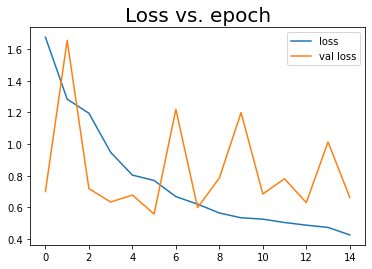

In [ ]:
# we want to see loss decreasing over time
# green - training loss
# blue - valication loss
plt.plot(hist.epoch, hist.history['loss'], label = 'loss');      
plt.plot(hist.epoch, hist.history['val_loss'], label = 'val loss');
plt.legend()
plt.title('Loss vs. epoch', fontsize=20);

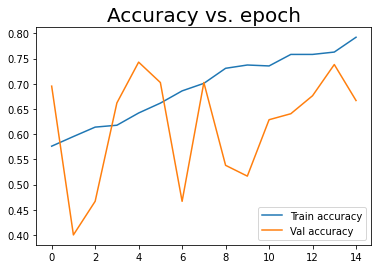

In [ ]:
# we want to see accuracy increase over time
plt.plot(hist.history ['acc'], label = 'Train accuracy')
plt.plot(hist.history ['val_acc'], label = 'Val accuracy')
plt.legend()
plt.title('Accuracy vs. epoch', fontsize=20);

## Predict

In [ ]:
cnnmodel.load_weights("/content/drive/MyDrive/DSI30/Capstone/weights.hdf5")

In [ ]:
cnnmodel.save('cnn_model')

In [ ]:
#model evaultion
cnnmodel.evaluate(test2_set,batch_size=32)

2/2 [==============================] - 5s 1s/step - loss: 0.6390 - acc: 0.6667


[0.6390157341957092, 0.6666666865348816]

In [ ]:
y_pred = tf.math.round(cnnmodel.predict(test2_set))
y_true = []
for images, labels in test2_set.unbatch():
  y_true.append(labels.numpy())

In [ ]:
accuracy_score(y_true, y_pred)

0.6666666666666666

In [ ]:
print(classification_report(y_true, y_pred, target_names=training_set.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.61      0.70      0.65        20
      Others       0.73      0.64      0.68        25

    accuracy                           0.67        45
   macro avg       0.67      0.67      0.67        45
weighted avg       0.67      0.67      0.67        45



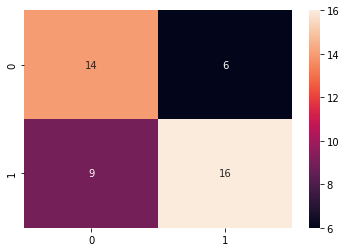

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm.astype("int"), annot=True);

In [ ]:
#primary account/computer

df = []


#for folder in  os.listdir(test_path) : 
files = gb.glob(pathname= str(test_path +'/' + 'Monkeypox' + '/*.jpg'))
for file in files:
  imagesplit = file.split('/')
  imagename = [imagesplit[11], imagesplit[10]]
  df.append(imagename)

files = gb.glob(pathname= str(test_path +'/' + 'Others' + '/*.jpg'))
for file in files:
  imagesplit = file.split('/')
  imagename = [imagesplit[11], imagesplit[10]]
  df.append(imagename)

df2 =[]
for pred in y_pred:
      pred = str(pred)
      filter = (pred.split('.'))[1]
      filter2 = (filter.split('['))[1]
      df2.append(filter2)

df = pd.DataFrame (df, columns = ['file_name', 'class'])

df['pred']= df2
df

,file_name,class,pred
0,M19_01.jpg,Monkeypox,1
1,M04_01.jpg,Monkeypox,0
2,M43_02.jpg,Monkeypox,1
3,M48_01.jpg,Monkeypox,1
4,M40_03.jpg,Monkeypox,0
5,M43_01.jpg,Monkeypox,0
6,M39_02.jpg,Monkeypox,0
7,M38_02.jpg,Monkeypox,0
8,M45_01.jpg,Monkeypox,0
9,M38_01.jpg,Monkeypox,1


In [ ]:
#creating dataframe for monkeypox and others
df_monkeypox = df.loc[df['class'] == 'Monkeypox']
df_others = df.loc[df['class'] == 'Others']

#misclassified df
df_monkeypox_false_negative = df_monkeypox.loc[df['pred'] == '1']
df_monkeypox_false_positive = df_others.loc[df['pred'] == '0']

In [ ]:
df_monkeypox_false_negative

,file_name,class,pred
0,M19_01.jpg,Monkeypox,1
2,M43_02.jpg,Monkeypox,1
3,M48_01.jpg,Monkeypox,1
9,M38_01.jpg,Monkeypox,1
16,M23_01.jpg,Monkeypox,1
17,M48_03.jpg,Monkeypox,1


In [ ]:
df_monkeypox_false_positive

,file_name,class,pred
25,NM14_01.jpg,Others,0
28,NM23_01.jpg,Others,0
32,NM36_01.jpg,Others,0
33,NM19_01.jpg,Others,0
34,NM12_01.jpg,Others,0
35,NM41_01.jpg,Others,0
36,NM02_01.jpg,Others,0
37,NM67_01.jpg,Others,0
38,NM85_01.jpg,Others,0
